#Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline   : 그래프를 주피터 노트북 화면상에 바로 띄울 수 있게하는 코드.
import seaborn as sns   # 쉽고 직관적인 방법으로 그래프를 띄울 수 있는 패키지
from scipy.stats import norm
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [80]:
path = '/content/drive/MyDrive/22_titanic/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'submission.csv')

## Test 결측치 처리

In [18]:
test.groupby('Pclass').mean()

,PassengerId,Age,SibSp,Parch,Fare
Pclass,,,,,
1,1098.224299,40.918367,0.476636,0.383178,94.280297
2,1117.935484,28.777500,0.376344,0.344086,22.202104
3,1094.178899,24.027945,0.463303,0.417431,12.459678


In [77]:
t1 = test[test['Pclass'] == 1].Age.fillna(41)
t2 = test[test['Pclass'] == 2].Age.fillna(29)
t3 = test[test['Pclass'] == 3].Age.fillna(24)

tt = [t1,t2,t3]
tt = pd.concat(tt)
test.Age = tt

In [78]:
test = test.fillna(test.mean())

In [21]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

## 코드 실행

In [81]:
## 불러오기
path = '/content/drive/MyDrive/22_titanic/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'submission.csv')

## Test 결측치 처리
t1 = test[test['Pclass'] == 1].Age.fillna(41)
t2 = test[test['Pclass'] == 2].Age.fillna(29)
t3 = test[test['Pclass'] == 3].Age.fillna(24)

tt = [t1,t2,t3]
tt = pd.concat(tt)
test.Age = tt
test = test.fillna(test.mean())
####

train=train.drop(columns='Cabin')
test=test.drop(columns='Cabin')
# 숫자로 바꿔주며 인코딩.
#train.loc[train['Sex']=='male', 'Sex']=0
#train.loc[train['Sex']=='female','Sex']=1
#test.loc[test['Sex']=='male','Sex']=0
#test.loc[test['Sex']=='female','Sex']=1
train['Sex']= train['Sex']=='male'
test['Sex']= test['Sex']=='male'

# 마찬가지로, 등급도 숫자형 변수가 아닌 범주형 변수이기 때문에 원핫인코딩
train['Pclass_3'] = (train['Pclass'] == 3)
train['Pclass_2'] = (train['Pclass'] == 2)
train['Pclass_1'] = (train['Pclass'] == 1)

test['Pclass_3'] = (test['Pclass'] == 3)
test['Pclass_2'] = (test['Pclass'] == 2)
test['Pclass_1'] = (test['Pclass'] == 1)

train = train.drop(columns = 'Pclass')
test = test.drop(columns = 'Pclass')
# 나이대 묶기
train['Age_band'] = pd.cut(train.Age, bins=[0,17,29,39,49,64,80], labels=['A','B','C','D','E','F'])
train['Age_band'].value_counts().to_frame()

#결측치 0으로 일단 모두 채우기
train['Age'] = train['Age'].fillna(0)
#RandomForest 모델을 이용해 Age 컬럼의 결측치를 채운다.
# 0으로 채워진 데이터와 아닌 데이터를 분리한다.
train0 = train.loc[train['Age'] == 0]
trainNot0 = train.loc[train['Age'] != 0]
#rf를 사용하기 전에 결측치가 있는 다른 컬럼은 학습에 방해가 되기 때문에 제거
# Age과 관련 없다고 생각되는 컬럼도 지운다.
trainNot0 = trainNot0.drop(columns = ['Name','Ticket','PassengerId','Embarked', 'Age_band'])
train0 = train0.drop(columns = ['Name','Ticket','PassengerId','Embarked', 'Age_band'])
# 범주형 변수 원핫인코딩 진행
trainNot0_dummies = pd.get_dummies(trainNot0)
train0_dummies = pd.get_dummies(train0)
# 전체 데이터 이용해서 모델 학습시키기
rf = RandomForestClassifier()
rf.fit(trainNot0_dummies, trainNot0['Age'].astype('int'))
rf_prediction = rf.predict(trainNot0_dummies)
rf_mse = mean_squared_error(trainNot0['Age'], rf_prediction)
rf_rmse = np.sqrt(rf_mse)
print(f'정확도 : {rf_rmse}')

train0_values = rf.predict(X = train0_dummies)
# 결측치를 채우기 위한 새로운 데이터프레임 생성
train0['Age'] = train0_values

data = trainNot0.append(train0)
data['Age'] = data['Age'].astype('int')
train.Age = data.Age

# Age_band 수정
train['old'] = (train['Age'] >= 64)
test['old'] = (test['Age'] >= 64)
train = train.drop(columns='Age_band')

# Embarked 결측치 처리
train.Embarked = train.Embarked.fillna('S')

# 원-핫 인코딩
train = pd.get_dummies(data = train, columns = ['Embarked'], prefix = 'Embarked')
test = pd.get_dummies(data = test, columns = ['Embarked'], prefix = 'Embarked')

# 본인을 포함한 가족 인원수
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# 범주화 해보기
train['Single']= train['FamilySize']==1
train['Nuclear']= (2<=train['FamilySize']) & (train['FamilySize']<=4)
train['Big']= train['FamilySize']>=5

test['Single']= test['FamilySize']==1
test['Nuclear']= (2<=test['FamilySize']) & (test['FamilySize']<=4)
test['Big']= test['FamilySize']>=5

# 다른 컬럼들 삭제
train = train.drop(columns=['Single','Big','FamilySize'])
test = test.drop(columns=['Single','Big','FamilySize'])

###
# Name의 유의미성 판단하기
train['Name']=train['Name'].str.split(', ').str[1].str.split('. ').str[0]
test['Name']=test['Name'].str.split(', ').str[1].str.split('. ').str[0]

train['Mrs'] = (train.Name == 'Mrs')
test['Mrs'] = (test.Name == 'Mrs')
train['Master'] = (train.Name == 'Master')
test['Master'] = (test.Name == 'Master')

train=train.drop(columns='Name')
test=test.drop(columns='Name')

##Fare
# 로그변환
train['log_Fare'] = train.Fare + 1
test['log_Fare'] = test.Fare + 1

train.log_Fare = np.log(train.log_Fare)
test.log_Fare = np.log(test.log_Fare)

## 나머지
train = train.drop(columns = ['PassengerId','Ticket','Fare','Parch','old'])
test = test.drop(columns = ['PassengerId','Ticket','Fare','Parch','old'])

정확도 : 0.10894515876828863


#Exploratory Data Analysis (EDA)

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S




*   PassengerID : 탑승객의 고유 아이디
*   Survived : 생존여부 (1:생존, 0:사망)
*   Pclass : 등실의 등급 (1:1등급 ...)
*   Sibsp : 함께 탑승한 형제자매, 아내 or 남편의 수
*   Parch : 함께 탑승한 부모, 자식의 수
*   Ticket : 티겟번호
*   Fare : 티겟 요금
*   Cabin : 객실번호
*   Embarked : 배에 탑승한 위치 (C = Cherbourg, Q = Queenstown, S = Southampton)
    *   이 배는 프랑스의 셰르부르(Cherbourg)와 아일랜드의 퀸즈 타운에 기항한 다음, 미국의 뉴욕으로 향했다.




In [23]:
print(f"------train 데이터셋 확인-----")
print(f"       {train.shape}")
print(f"------test 데이터셋 확인-----")
print(f"       {test.shape}")
print(f"------submission 데이터셋 확인-----")
print(f"       {submission.shape}")

------train 데이터셋 확인-----
       (891, 12)
------test 데이터셋 확인-----
       (418, 11)
------submission 데이터셋 확인-----
       (418, 2)


## 통계량

In [24]:
print(f"---------------------train 데이터셋 info---------------------")
print(f"       {train.info()}")
print(f"-------train셋 결측치 확인: {train.isna().sum()}")
print(f"---------------------test 데이터셋 info---------------------")
print(f"       {test.info()}")
print(f"-------test셋 결측치 확인: {test.isna().sum()}")
print(f"---------------------submission 데이터셋 info---------------------")
print(f"       {submission.info()}")
print(f"-------submission셋 결측치 확인: {submission.isna().sum()}")

---------------------train 데이터셋 info---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
       None
-------train셋 결측치 확인: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0


In [25]:
train=train.drop(columns='Cabin')
test=test.drop(columns='Cabin')

In [26]:
#기술통계량 describe
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


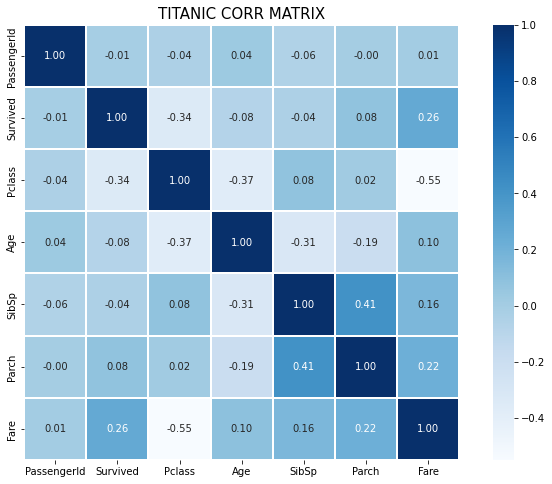

In [27]:
plt.figure(figsize=(12, 8))
plt.title("TITANIC CORR MATRIX", size = 15)
sns.heatmap(train.corr(),
            square=True,
            annot=True,
            fmt='.2f',
            linewidth = 1,
            cmap="Blues")
plt.show()

## Sex

In [28]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

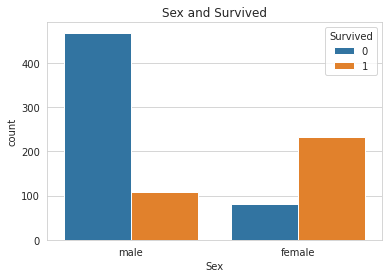

In [29]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Sex and Survived')
plt.show()
# 남자는 사망자 수가, 여자는 생존자 수가 더 많음. 여자의 생존률이 더 높음.

In [30]:
# 숫자로 바꿔주며 인코딩.
train.loc[train['Sex']=='male', 'Sex']=0
train.loc[train['Sex']=='female','Sex']=1
test.loc[test['Sex']=='male','Sex']=0
test.loc[test['Sex']=='female','Sex']=1

In [31]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [32]:
train['Sex'] = pd.to_numeric(train['Sex'])

In [33]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

## Pclass 객실등급

In [34]:
train['Pclass'].unique()

array([3, 1, 2])

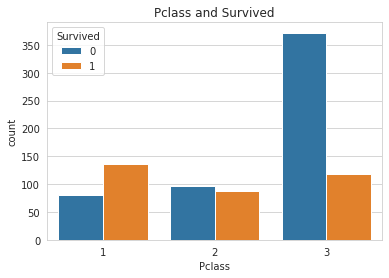

In [35]:
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Pclass and Survived')
plt.show()
# 등급이 낮을수록 생존자보다 사망자 비율이 더욱 높아짐. 특히, 3등급 : 사람수도 많고 사망자도 많음.

In [36]:
#train[['Pclass', 'Fare','Survived','SibSp', 'Parch']].groupby('Pclass').mean()
train.groupby('Pclass').mean()
# 등급으로 평균 지어 보면 다음과 같음.
# 등급에 따른 성별 비율도 확인하기 위해 성별 숫자화.
# 3등급에는 남자 비율이 훨씬 많음. 아마 등급 낮은 여자는 탑승도 못했을 것으로 추정.
# 하지만 성별은 범주형 변수이기 때문에 다시 문자화.

# 나이, 요금은 반비례 관계.
# 등급이 낮을수록 딸려 있는 일행이 많은 경향.

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare
Pclass,,,,,,,
1,461.597222,0.629630,0.435185,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,0.413043,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,0.293279,25.140620,0.615071,0.393075,13.675550


In [37]:
train['Sex'] = train['Sex'].astype('str')

In [38]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [39]:
# 마찬가지로, 등급도 숫자형 변수가 아닌 범주형 변수이기 때문에 원핫인코딩
train['Pclass_3'] = (train['Pclass'] == 3)
train['Pclass_2'] = (train['Pclass'] == 2)
train['Pclass_1'] = (train['Pclass'] == 1)

test['Pclass_3'] = (test['Pclass'] == 3)
test['Pclass_2'] = (test['Pclass'] == 2)
test['Pclass_1'] = (test['Pclass'] == 1)

train = train.drop(columns = 'Pclass')
test = test.drop(columns = 'Pclass')

## Age

In [40]:
print(f"Age 변수 최고값 : {train['Age'].max()}")
print(f"Age 변수 최저값 : {train['Age'].min()}")

Age 변수 최고값 : 80.0
Age 변수 최저값 : 0.42


In [41]:
# 나이대 묶기
train['Age_band'] = pd.cut(train.Age, bins=[0,17,29,39,49,64,80], labels=['A','B','C','D','E','F'])
train['Age_band'].value_counts().to_frame()

,Age_band
B,271
C,167
A,113
D,89
E,63
F,11


In [42]:
# 나이와 다른 변수들 및 종속변수와 상관성 살펴보고 결측치 처리 결정하기
def my_summary(x):
    result = {
        'sum':x.sum(),
        'count':x.count(),
        'mean':x.mean(),
        'median':x.median(),
        'variance':x.var()
    }
    return result

train.groupby('Age_band')['SibSp'].apply(my_summary).unstack()

,sum,count,mean,median,variance
Age_band,,,,,
A,165.0,113.0,1.460177,1.0,2.643489
B,89.0,271.0,0.328413,0.0,0.376930
C,59.0,167.0,0.353293,0.0,0.326239
D,33.0,89.0,0.370787,0.0,0.281410
E,19.0,63.0,0.301587,0.0,0.278546
F,1.0,11.0,0.090909,0.0,0.090909


In [43]:
train['Age_band'] = pd.cut(train.Age, bins=5)
train.groupby('Age_band').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_3,Pclass_2,Pclass_1
Age_band,,,,,,,,,
"(0.34, 16.336]",430.020000,0.550000,8.006700,1.570000,1.140000,31.588877,0.700000,0.210000,0.090000
"(16.336, 32.252]",448.263006,0.369942,24.495665,0.335260,0.242775,28.260499,0.586705,0.242775,0.170520
"(32.252, 48.168]",457.478723,0.404255,39.239362,0.367021,0.468085,42.788940,0.372340,0.260638,0.367021
"(48.168, 64.084]",460.057971,0.434783,54.847826,0.333333,0.289855,50.327235,0.130435,0.246377,0.623188
"(64.084, 80.0]",403.363636,0.090909,69.772727,0.090909,0.181818,28.905691,0.272727,0.181818,0.545455


나이가 어릴 수록 가족 수가 많음. 특히, 형제자매 수가 많음.

또한 나이 3~50대에 지불하는 요금이 높음. 하지만 30대에는 3등급이 

많으며, 4~60대에 1등급이 많은 것을 볼 수 있음.



---


F층을 보니, 등급이 높은 사람이 많음에도 불구하고 생존율은 매우 낮음. 
노약자는 등급보다도 나이에 영향을 더 받아서 사망 비율이 높음.

A층은 등급이 낮은데도 불구하고 어린이를 우선하여 구출했는지 생존율이 높음.
즉, 어린이는 등급보다 나이에 영향을 더 받아서 생존 비율이 높음.



---


따라서 나이는, 유의미한 변수임을 확인할 수 있음.

###Age 결측치

In [44]:
#결측치 0으로 일단 모두 채우기
train['Age'] = train['Age'].fillna(0)

In [45]:
#RandomForest 모델을 이용해 Age 컬럼의 결측치를 채운다.
# 0으로 채워진 데이터와 아닌 데이터를 분리한다.
train0 = train.loc[train['Age'] == 0]
trainNot0 = train.loc[train['Age'] != 0]

print(f'0으로 채워진 결측치의 수 : {train0.shape}')
print(f'결측치가 아닌 데이터의 수 : {trainNot0.shape}')

#rf를 사용하기 전에 결측치가 있는 다른 컬럼은 학습에 방해가 되기 때문에 제거
# Age과 관련 없다고 생각되는 컬럼도 지운다.
trainNot0 = trainNot0.drop(columns = ['Name','Ticket','PassengerId','Embarked', 'Age_band'])
print(f'trainNot0의 shape : {trainNot0.shape}')
train0 = train0.drop(columns = ['Name','Ticket','PassengerId','Embarked', 'Age_band'])
print(f'train0의 shape : {train0.shape}')

# 범주형 변수 원핫인코딩 진행
trainNot0_dummies = pd.get_dummies(trainNot0)
print(f'trainNot0_dummies의 shape : {trainNot0_dummies.shape}')
train0_dummies = pd.get_dummies(train0)
print(f'train0_dummies의 shape : {train0_dummies.shape}')

0으로 채워진 결측치의 수 : (177, 14)
결측치가 아닌 데이터의 수 : (714, 14)
trainNot0의 shape : (714, 9)
train0의 shape : (177, 9)
trainNot0_dummies의 shape : (714, 10)
train0_dummies의 shape : (177, 10)


In [46]:
rf = RandomForestClassifier()

# 전체 714 row중 오차지표 확인을 위해 600개 데이터 1차 학습
rf.fit(trainNot0_dummies[:600], trainNot0['Age'][:600].astype('int'))

# rmse가 약 4정도로 양호한것을 확인
rf_prediction = rf.predict(trainNot0_dummies[600:])
rf_mse = mean_squared_error(trainNot0['Age'][600:], rf_prediction)
rf_rmse = np.sqrt(rf_mse)
print(f'정확도 : {rf_rmse}')

정확도 : 3.9336873911418118


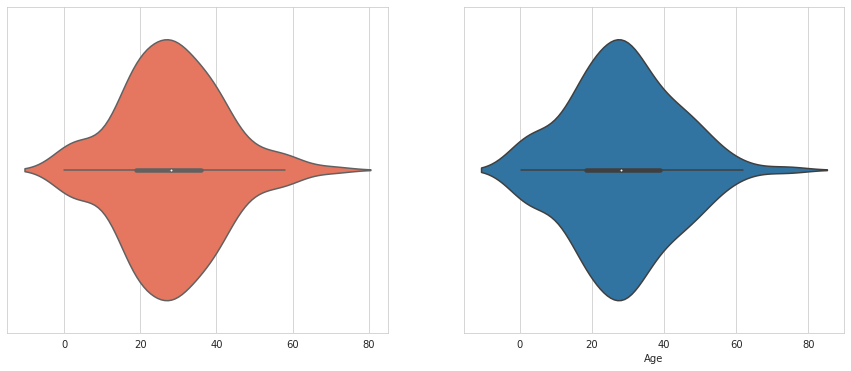

In [47]:
# 예측한 데이터 분포 살펴보기
plt.figure(figsize=(15,6))

# 예측 데이터
plt.subplot(121)
sns.violinplot(rf_prediction,palette='Reds')

# 실제 데이터
plt.subplot(122)
sns.violinplot(trainNot0['Age'][600:])

plt.show()

rmse 평가 지수와 데이터 분포를 비교하여 살펴보았을때,

예측이 잘 된 것으로 판단하고 전체 데이터의 Age에 대해 적용하도록 한다.



In [48]:
# 전체 데이터 이용해서 다시 모델 학습시키기
rf.fit(trainNot0_dummies, trainNot0['Age'].astype('int'))

train0_values = rf.predict(X = train0_dummies)
train0_values

array([16, 18, 15, 17, 13, 16, 17, 16, 20, 16, 16, 11, 16, 16, 16, 18,  0,
       16, 16, 16, 16, 16, 16, 16, 14, 16, 16,  0,  1, 17, 16,  1, 16, 18,
        2,  1, 16, 19, 14, 16, 16,  1, 17, 16,  2, 14, 14, 14, 17, 16, 16,
       14, 18, 16, 16, 18, 18, 16, 16, 12, 17, 16, 16,  1,  0, 17, 16, 14,
       18, 17, 13, 13, 11, 13, 16, 17, 16, 16,  2, 16, 17, 16, 14, 16, 17,
       16, 14, 16, 11, 16, 17, 16, 16, 16, 16, 17, 19, 16,  2, 11, 11, 11,
       14, 16, 16, 11, 17, 17, 22, 17,  0, 11,  0, 16, 22, 16, 16, 14, 17,
       16, 14, 16, 16,  0, 19, 17, 16, 16, 17, 14, 16, 16, 19, 11, 11, 16,
       16, 13, 16, 16, 17, 16, 14, 11, 16,  0, 18, 11, 16, 16, 16, 16, 26,
       11, 16, 11, 17, 16, 16,  1, 16,  1, 18, 19, 17, 11, 16, 17, 16, 26,
        1, 17, 17,  1, 16, 16,  2])

In [49]:
# 결측치를 채우기 위한 새로운 데이터프레임 생성
train0['Age'] = train0_values
data = trainNot0.append(train0)
data['Age'] = data['Age'].astype('int')
train['Age'] = data['Age']

In [50]:
print(f'나이 최소값 : {train.Age.min()}')
print(f'나이 최대값 : {train.Age.max()}')

나이 최소값 : 0
나이 최대값 : 80


In [51]:
# 나이대 묶기
train['Age_band'] = pd.cut(train.Age, bins=[-1,17,29,39,49,64,80], labels=['A','B','C','D','E','F'])
train['Age_band'].value_counts().to_frame()

,Age_band
B,290
A,271
C,167
D,89
E,63
F,11


In [52]:
train.isnull().sum()

PassengerId    0
Survived       0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Pclass_3       0
Pclass_2       0
Pclass_1       0
Age_band       0
dtype: int64

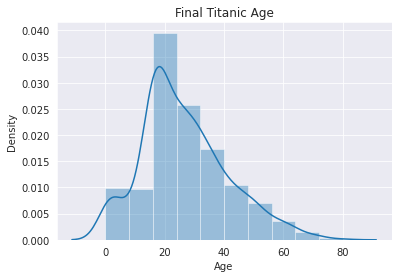

In [53]:
sns.set_style('darkgrid')
sns.distplot(train.Age, bins =10)
plt.title('Final Titanic Age')
plt.show()

### Age_band

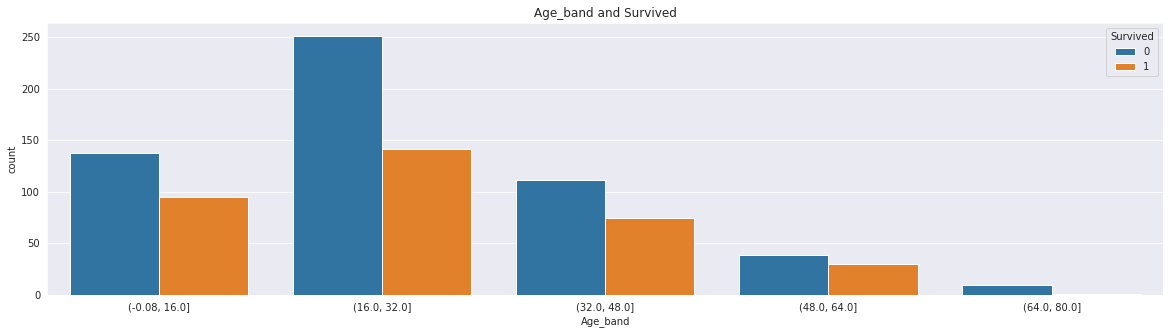

In [54]:
# 나이대 생존 분포 확인하기
train['Age_band'] = pd.cut(train.Age, bins=5)
# train['Age_band'].value_counts().to_frame()

plt.figure(figsize=(20,5))
sns.countplot(data = train, x = 'Age_band', hue = 'Survived')
plt.title('Age_band and Survived')
plt.show()

In [57]:
# Age_band가 0~6.154에 해당되는 그룹의 생존율이 높음 - Age_band를 삭제하고 0~6세 이하의 사람을 영유아 그룹처리 함.
train['chlid'] = (train['Age'] <= 6.154)
test['chlid'] = (test['Age'] <= 6.154)

## Embarked

### 결측치 처리

최빈값으로 삽입

In [ ]:
train.Embarked.value_counts().to_frame()

In [ ]:
train.Embarked = train.Embarked.fillna('S')
train.isnull().sum()

### 변수 유의미성 판단

In [ ]:
sns.countplot(data = train, x = 'Embarked', hue = 'Survived')
plt.show()

C 선착장에서 탑승한 사람들은 생존율이 높은 것을 볼 수 있다.

또한 S와 Q에서의 생존율에 차이가 꽤 나기 때문에 이 변수는 지우지 않고

원-핫 인코딩을 실시한다.

In [ ]:
# 원-핫 인코딩
train = pd.get_dummies(data = train, columns = ['Embarked'], prefix = 'Embarked')
test = pd.get_dummies(data = test, columns = ['Embarked'], prefix = 'Embarked')

# Feature Engineering



### FamilySize

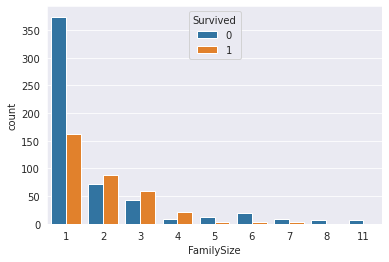

In [58]:
# 본인을 포함한 가족 인원수
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

sns.countplot(data = train, x = 'FamilySize', hue = 'Survived')
plt.show()

FamilySize가 2~4인 경우 생존율이 더 높다는 유의미한 결과를 거둠.

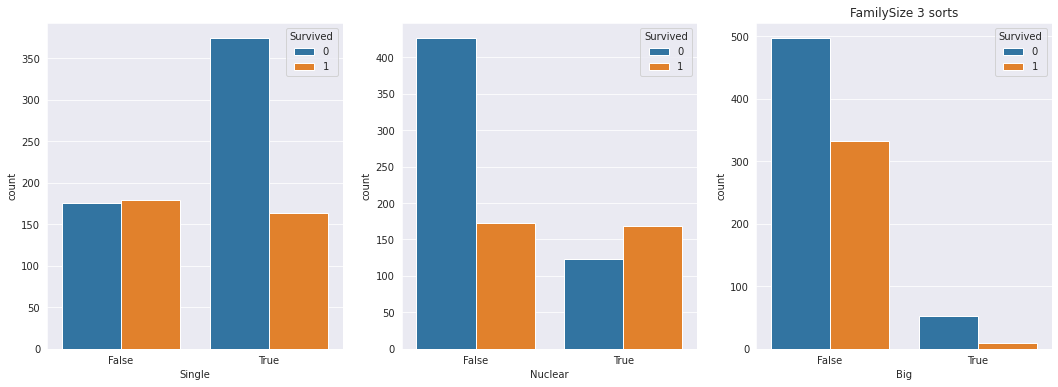

In [59]:
# 범주화 해보기
train['Single']= train['FamilySize']==1
train['Nuclear']= (2<=train['FamilySize']) & (train['FamilySize']<=4)
train['Big']= train['FamilySize']>=5

test['Single']= test['FamilySize']==1
test['Nuclear']= (2<=test['FamilySize']) & (test['FamilySize']<=4)
test['Big']= test['FamilySize']>=5

figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,6)
sns.countplot(data=train, x='Single', hue='Survived', ax=ax1)
sns.countplot(data=train, x='Nuclear', hue='Survived', ax=ax2)
sns.countplot(data=train, x='Big',hue='Survived', ax=ax3) 
plt.title('FamilySize 3 sorts')
plt.show()

2~4인 가구에 해당되느냐 안되느냐로 생존율 구분할 수 있음.

따라서 FamilySize 와 같은 다른 변수들은 모두 지우고 Nuclear만 남겨둠.

In [60]:
train = train.drop(columns=['Single','Big','FamilySize'])
test = test.drop(columns=['Single','Big','FamilySize'])

### SibSp, Parch

SibSp 나 Parch는 FamilySize와 별개로 유의미한 변수인가.

### Name

In [61]:
train.Name.head(5).to_frame()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


'이름', Mr. '성씨' 형태로 깔끔하게 정리되어 있음.

여기서 가운데에 적힌 신분만 따와서 살펴보겠음.

In [62]:
# Name의 유의미성 판단하기
train['Name']=train['Name'].str.split(', ').str[1].str.split('. ').str[0]
test['Name']=test['Name'].str.split(', ').str[1].str.split('. ').str[0]

In [63]:
train.Name.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'th', 'Jonkheer'],
      dtype=object)

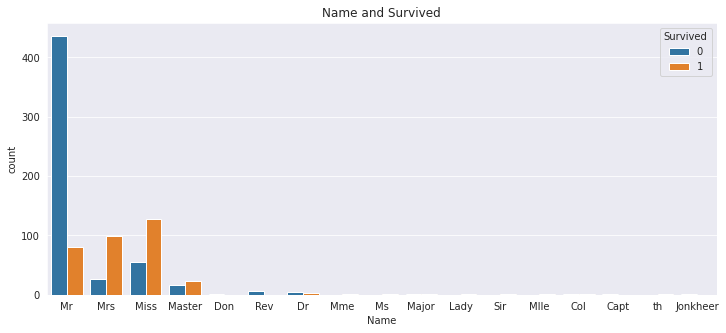

In [64]:
plt.figure(figsize=(12,5))
sns.countplot(data = train, x = 'Name', hue = 'Survived')
plt.title('Name and Survived')
plt.show()



*   Mr : 기혼, 미혼 구분없이 남자를 부르는 말
*   Mrs : 결혼한 여자를 부르는 말
*   Miss : 미혼 여성을 부르는 말
*   Master : 어린 남자아이를 부르는 말

같은 여성 중에서도 결혼의 유무에 따라 생존율이 차이남.

어린 남자아이는 다른 변수에 비해 생존율이 높은 이유가 나이 때문인데,

나이 변수는 결측치 처리하여 살려냈으므로 생략.

Mrs 유무만 판별.



In [65]:
# Mrs 추가하고 Name 삭제
train['Mrs'] = (train.Name == 'Mrs')
test['Mrs'] = (test.Name == 'Mrs')
train['Master'] = (train.Name == 'Master')
test['Master'] = (test.Name == 'Master')
train=train.drop(columns='Name')
test=test.drop(columns='Name')

## Ticket

In [66]:
train = train.drop(columns = 'Ticket')
test = test.drop(columns = 'Ticket')

## Fare

In [67]:
train.Fare.min()

0.0

In [68]:
train[train.Fare <= 6].mean().Survived

0.058823529411764705

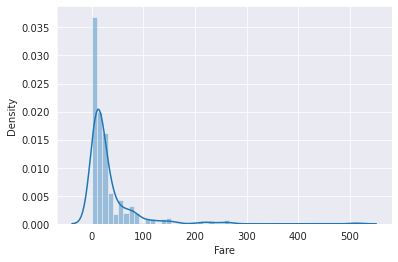

In [69]:
sns.distplot(train['Fare'])
plt.show()

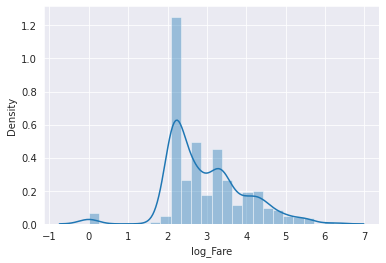

In [70]:
# 로그변환
train['log_Fare'] = train.Fare + 1
test['log_Fare'] = test.Fare + 1

train.log_Fare = np.log(train.log_Fare)
test.log_Fare = np.log(test.log_Fare)

sns.distplot(train.log_Fare)
plt.show()

In [71]:
train['Free'] = (train.Fare <= 6)
test['Free'] = (test.Fare <= 6)

## 나머지

In [72]:
train = train.drop(columns = ['PassengerId'])
test = test.drop(columns = ['PassengerId'])

train.loc[train['Survived']==1, 'Survived']='1'
train.loc[train['Survived']==0,'Survived']='0'

# Modeling

In [82]:
train.dtypes

Survived        int64
Sex              bool
Age             int64
SibSp           int64
Pclass_3         bool
Pclass_2         bool
Pclass_1         bool
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
Nuclear          bool
Mrs              bool
Master           bool
log_Fare      float64
dtype: object

In [83]:
Ytrain = train['Survived']
feature_names = list(test)
Xtrain = train[feature_names]
Xtest = test[feature_names]   # test 데이터

print(f'Xtrain shape: {Xtrain.shape}')
print(f'Ytrain shape: {Ytrain.shape}')
print(f'Xtest shape: {Xtest.shape}')

X_train, X_test, y_train, y_test = train_test_split(Xtrain, Ytrain,
                                                    test_size = .3,
                                                    random_state = 5,
                                                   stratify = Ytrain)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

Xtrain shape: (891, 13)
Ytrain shape: (891,)
Xtest shape: (418, 13)
X_train shape: (623, 13)
y_train shape: (623,)


In [84]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.8582089552238806

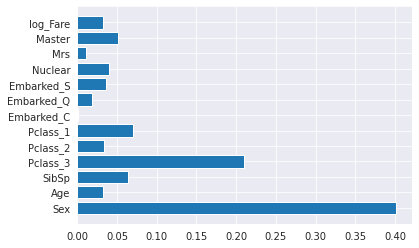

In [85]:
#변수 중요도
xgb.feature_importances_

plt.barh(feature_names, xgb.feature_importances_)
plt.show()

In [86]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(500,1000,100),
    'max_depth': range(4, 10),
    'learning_rate': [0.01,0.05,0.1,0.15],
    'colsample_bytree': [.5, .6, .7, .8, .9, 1],
    'subsample':[i/10.0 for i in range(6,10)]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(objective= 'binary:logistic',
                     nthread=-1, 
                     scale_pos_weight=1)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                estimator = gbm, 
                                scoring = "accuracy", 
                                verbose = 1, n_iter = 200, cv = 4)

# Fit randomized_mse to the data
xgb_random.fit(Xtrain, Ytrain)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1}
Best accuracy found:  0.848498161838969


In [87]:
param_test1 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gbm2 = XGBClassifier(subsample = 0.8,
                     n_estimators = 600,
                     max_depth = 5,
                     learning_rate = 0.01,
                     colsample_bytree = 0.6,
                     objective= 'binary:logistic',
                     nthread=-1, 
                     scale_pos_weight=1)
xgb_gread = GridSearchCV(estimator = gbm2, param_grid = param_test1,
                         scoring = "accuracy", cv=4, verbose=1)
# Fit randomized_mse to the data
xgb_gread.fit(Xtrain, Ytrain)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_gread.best_params_)
print("Best accuracy found: ", xgb_gread.best_score_)

Fitting 4 folds for each of 35 candidates, totalling 140 fits
Best parameters found:  {'max_depth': 7, 'min_child_weight': 2}
Best accuracy found:  0.8507352644123946


In [88]:
param_test2 = {
 'gamma' :[0.001, 0.01, 0.1, 1, 10, 100]
}
gbm2 = XGBClassifier(subsample = 0.8,
                     n_estimators = 600,
                     max_depth = 7,
                     min_child_weight = 2,
                     learning_rate = 0.01,
                     colsample_bytree = 0.6,
                     gamma = 0.001,
                     reg_alpha = 1e-05,
                     objective= 'binary:logistic',
                     nthread=-1, 
                     scale_pos_weight=1)
xgb_gread = GridSearchCV(estimator = gbm2, param_grid = param_test2,
                         scoring = "accuracy", cv=4, verbose=1)
# Fit randomized_mse to the data
xgb_gread.fit(Xtrain, Ytrain)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_gread.best_params_)
print("Best accuracy found: ", xgb_gread.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best parameters found:  {'gamma': 0.001}
Best accuracy found:  0.8507403143053367


In [92]:
# 최종 예측
xgb = XGBClassifier(subsample = 0.8,
                     n_estimators = 600,
                     max_depth = 7,
                     min_child_weight = 2,
                     learning_rate = 0.01,
                     colsample_bytree = 0.6,
                     gamma = 0.001,
                     reg_alpha = 1e-05,
                     objective= 'binary:logistic',
                     nthread=-1, 
                     scale_pos_weight=1)

xgb.fit(Xtrain, Ytrain)
submission['Survived'] = xgb.predict(Xtest)
submission.to_csv('titanic_submission.csv', header = True, index = False)